In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Tuple

import tensorflow as tf

from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.metrics import confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay, root_mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FactorAnalysis
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler

import shap

from visualization import plot_predicted_vs_true

2025-02-27 11:27:35.334390: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
np.set_printoptions(suppress=True)

## Data Loading

In [9]:
train_data_full = pd.read_csv("data/train_data.csv", sep=";")
test_data_full = pd.read_csv("data/test_data.csv", sep=";")

train_data_full= train_data_full[train_data_full["attention_check"] == 1]

In [10]:
train_data_full.head()

,subject,country,rel_1,rel_2,rel_3,rel_4,rel_5,rel_6,rel_7,rel_8,...,gender,ses,education,ethnicity,denomination,gdp,gdp_scaled,sample_type,compensation,attention_check
0,5362,Ireland,0.833333,0.857143,1.0,1,0.833333,0.833333,1.000000,1.00,...,woman,6.0,4,Caucasian/European,Christian (Roman Catholic),78806.431996,1.973267,online panel,monetary reward,1
1,10070,UK,0.000000,0.000000,0.0,0,0.166667,0.166667,0.166667,0.00,...,woman,5.0,3,Caucasian/European,NaN,42491.364435,0.332479,online panel,monetary reward,1
2,9515,Turkey,0.000000,0.000000,0.5,0,0.000000,0.500000,0.000000,0.00,...,man,6.0,5,Middle-Eastern/Arab,NaN,9311.366117,-1.166661,online panel,monetary reward,1
3,5960,Israel,0.500000,0.428571,0.5,0,0.166667,0.500000,0.666667,0.25,...,woman,7.0,4,Mixed / other,NaN,41613.998082,0.292837,students,course credit,1
4,6935,Lithuania,0.000000,0.000000,0.5,1,0.166667,0.666667,0.166667,0.00,...,woman,7.0,3,Caucasian/European,Christian (Roman Catholic),19089.707506,-0.724855,students,no compensation,1


In [11]:
predictors = ['rel_1', 'rel_2', 'rel_3', 'rel_4', 'rel_5', 'rel_6', 'rel_7', 'rel_8', 'rel_9', \
              'cnorm_1', 'cnorm_2', 'age', 'gender', 'ethnicity', 'education', 'gdp', 'gdp_scaled', \
              'sample_type', 'compensation', 'denomination', 'country', 'ses']
regression_targets = ['wb_overall_mean', 'wb_phys_mean', 'wb_psych_mean', 'wb_soc_mean']
# regression_targets = ['wb_overall_mean']


def justify_X(X: 'pd.DataFrame', use_wb_soc_3: bool = False) -> 'pd.DataFrame': 
    # List needed dummies
    dummies_needed = ['rel_3', 'rel_4', 'gender', 'ethnicity', 'sample_type', 'compensation', 'denomination', 'country']
    if use_wb_soc_3: 
        dummies_needed.append('answered_sex_life_question')

    # Grab predictor columns
    X_new = X[predictors]

    # Get whether they answered the sexlife question as its own variable
    if use_wb_soc_3: 
        X_new.loc[:, 'answered_sex_life_question'] = X['wb_soc_3'].isna()

    # Do imputations
    for column in X_new.columns: 
        if sum(X_new[column].isna()) == 0:
            continue
        if column not in dummies_needed: 
            X_new[column] = X_new[column].fillna(X_new[column].mean())
            continue
    
    # Get dummies
    dummies_with_na = list(filter(lambda x: sum(X_new[x].isna()) > 0, dummies_needed))
    dummies_without_na = list(filter(lambda x: x not in dummies_with_na, dummies_needed))
    X_new = pd.get_dummies(X_new, columns=dummies_with_na, dummy_na=True)
    return(pd.get_dummies(X_new, columns=dummies_without_na, dummy_na=False))


def justify_data(data: 'pd.DataFrame', use_wb_soc_3: bool = True, test_size: float = .2, seed: int = 42, random: bool = False) -> \
            Tuple['pd.DataFrame', 'pd.DataFrame', 'pd.DataFrame', 'pd.DataFrame']: 
    
    X = justify_X(data, use_wb_soc_3=use_wb_soc_3)
    y = data[regression_targets]
    
    if random: 
        return train_test_split(X, y, test_size=test_size)
    return train_test_split(X, y, test_size=test_size, random_state=seed)

In [12]:
X_train_w_soc3, X_test_w_soc3, y_train_w_soc3, y_test_w_soc3 = justify_data(train_data_full)
X_train, X_test, y_train, y_test = justify_data(train_data_full, use_wb_soc_3=False)
X_real_world = justify_X(test_data_full, use_wb_soc_3=False)

/var/folders/pw/fd4pnrrx6wd9wgr2zmtjqqb80000gn/T/ipykernel_27585/2284876681.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_new.loc[:, 'answered_sex_life_question'] = X['wb_soc_3'].isna()
/var/folders/pw/fd4pnrrx6wd9wgr2zmtjqqb80000gn/T/ipykernel_27585/2284876681.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_new[column] = X_new[column].fillna(X_new[column].mean())
/var/folders/pw/fd4pnrrx6wd9wgr2zmtjqqb80000gn/T/ipykernel_27585/2284876681.py:26: SettingWithCopyWarning: 
A value is trying to 

In [13]:
X_train.head()


,rel_1,rel_2,rel_5,rel_6,rel_7,rel_8,rel_9,cnorm_1,cnorm_2,age,...,country_Japan,country_Lithuania,country_Morocco,country_Netherlands,country_Romania,country_Singapore,country_Spain,country_Turkey,country_UK,country_US
1197,0.000000,0.857143,1.000000,1.000000,1.000000,0.00,0.50,0.50,0.50,25.0,...,False,False,False,False,False,False,False,False,False,False
7456,0.166667,0.142857,0.833333,0.666667,1.000000,0.00,0.00,0.50,0.75,28.0,...,False,False,False,False,False,False,False,False,False,False
7636,0.000000,0.142857,1.000000,1.000000,1.000000,0.00,1.00,0.00,0.75,36.0,...,False,False,False,False,False,False,False,False,False,False
6600,0.500000,0.571429,0.000000,0.833333,0.833333,0.25,0.75,0.25,0.25,26.0,...,False,False,False,False,False,False,False,False,False,False
8024,0.166667,0.857143,0.500000,0.500000,0.166667,0.25,0.25,0.50,0.50,60.0,...,True,False,False,False,False,False,False,False,False,False


## Linear Model

In [14]:
lr_fit = LinearRegression().fit(X_train, y_train)

In [15]:
lr_preds = lr_fit.predict(X_test)
lr_rmse = root_mean_squared_error(y_test, lr_preds)
print(lr_rmse)

0.6415166333089317


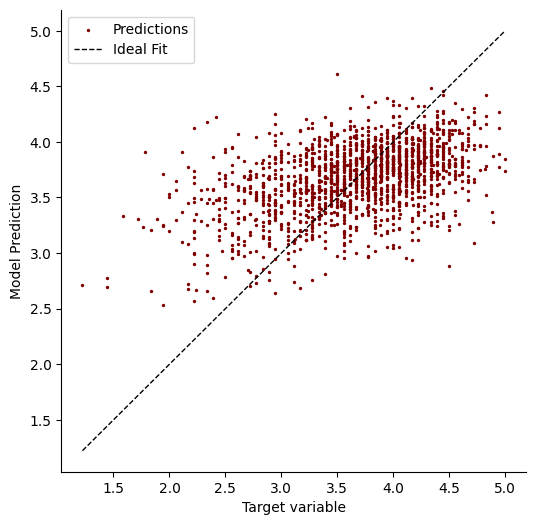

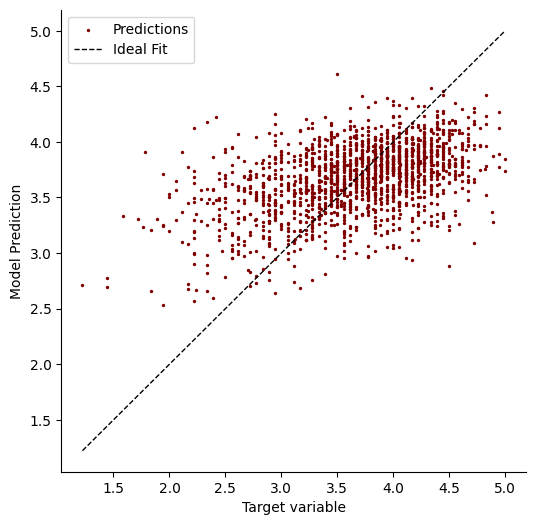

In [16]:
plot_predicted_vs_true(lr_preds[:,0], y_test['wb_overall_mean'])

## Random Forest

In [17]:
# Generate and fit model over MOE data
rfr = RandomForestRegressor(
    n_estimators=500,          # Number of trees
    max_depth=10,              # Limit the depth of each tree
    min_samples_split=5,       # Minimum samples required to split a node
    min_samples_leaf=3,        # Minimum samples required to be at a leaf node
    max_features='sqrt',       # Number of features to consider for splitting at each node
    random_state=42            # For reproducibility
)
rfr.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=5, n_estimators=500, random_state=42)

In [18]:
rf_preds = rfr.predict(X_test)
rf_rmse = root_mean_squared_error(y_test, rf_preds)
print(rf_rmse)

0.6453683631487136


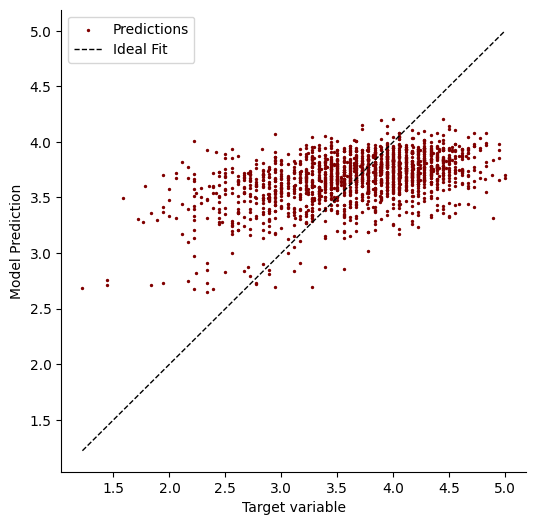

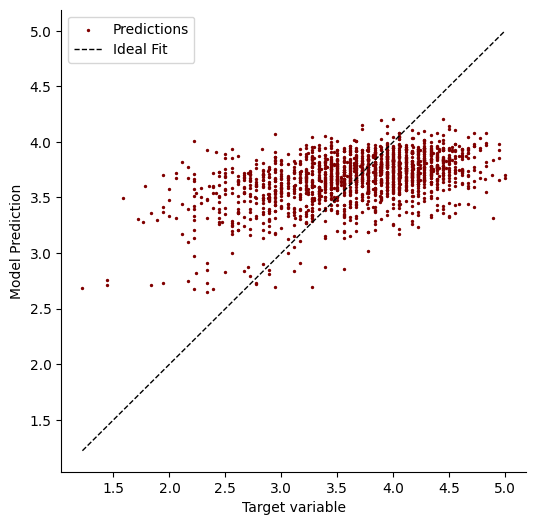

In [19]:
plot_predicted_vs_true(rf_preds[:,0], y_test['wb_overall_mean'])

## Neural Network

In [ ]:
# Ran out of time to fix this! As discussed in class, I need to scale the data.

# nn_model = tf.keras.Sequential([
#     tf.keras.Input(shape=(X_train.shape[1],)),
#     tf.keras.layers.Dense(124, activation="relu"),
#     tf.keras.layers.Dense(124, activation="relu"),
#     tf.keras.layers.Dense(124, activation="relu"),
#     tf.keras.layers.Dense(4, activation="linear")
# ])

# # Spe fy the optimizer
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# # Compiling the model
# nn_model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=["root_mean_squared_error"])

# # Training the model
# history = nn_model.fit(x=X_train, y=y_train, batch_size=32, epochs=150, validation_split=0.1)

Epoch 1/150
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 147669.1562 - root_mean_squared_error: 335.9294 - val_loss: 2.7711 - val_root_mean_squared_error: 1.6646
Epoch 2/150
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.8095 - root_mean_squared_error: 1.6760 - val_loss: 2.7281 - val_root_mean_squared_error: 1.6517
Epoch 3/150
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.7929 - root_mean_squared_error: 1.6712 - val_loss: 2.6500 - val_root_mean_squared_error: 1.6279
Epoch 4/150
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.8430 - root_mean_squared_error: 1.6861 - val_loss: 2.7601 - val_root_mean_squared_error: 1.6613
Epoch 5/150
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.6999 - root_mean_squared_error: 1.6431 - val_loss: 2.9173 - val_root_mean_squared_error: 1.7080
Epoch 6/150
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.8164 - root_mean_squared_error: 1.6781 - val_loss: 2.5646 - val_root_mean_squared_error: 1.6015
Epoch 7/150
207/207 ━━━━━━━━━━━━━━━━━━━

In [164]:
# nn_preds = nn_model.predict(X_test)
# nn_rmse = root_mean_squared_error(y_test, nn_preds)
# print(nn_rmse)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
0.7137449979782104


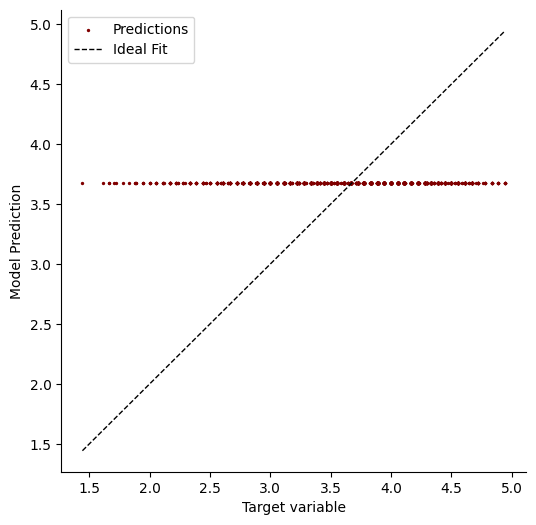

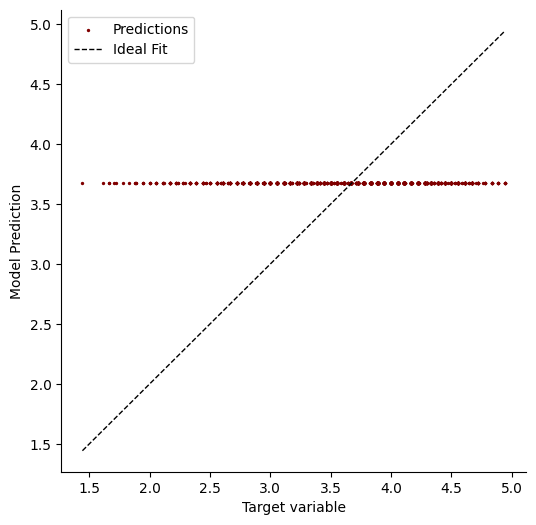

In [165]:
# plot_predicted_vs_true(nn_preds[:,0], y_test['wb_overall_mean'])

## Predictions

Based on the above graphs, we believe the linear model is the best; this is what we'll use to make predictions.

In [21]:
submission_data = justify_X(test_data_full)
preds = lr_fit.predict(submission_data)

/var/folders/pw/fd4pnrrx6wd9wgr2zmtjqqb80000gn/T/ipykernel_27585/2284876681.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_new[column] = X_new[column].fillna(X_new[column].mean())


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- denomination_Christian
- denomination_Druze
- denomination_Jain
- denomination_Muslim (Azhari)
- denomination_Shinto
- ...


## Feature Importance

In [ ]:
scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

lr_r = permutation_importance(lr_fit, X_test, y_test, n_repeats=30, random_state=42, scoring=scorer)
rf_r = permutation_importance(rfr, X_test, y_test, n_repeats=30, random_state=42, scoring=scorer)

In [196]:
# Assuming rf_r is the result from permutation_importance
importances = lr_r.importances_mean  # Mean importance for each feature
importances_std = lr_r.importances_std  # Standard deviation of importance

# Assuming X_test.columns contains the names of your features
feature_names = X_test.columns

# Create a DataFrame with features and their importance values
lr_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances,
    'Importance_std': importances_std
})

# Sort the DataFrame by Importance (descending order) to find the most important features
lr_importance_df = lr_importance_df.sort_values(by='Importance', ascending=False)

# Print the features with the greatest importance
print(lr_importance_df)

                         Feature  Importance  Importance_std
13                           ses    0.066181        0.004048
58                    gender_man    0.005678        0.000789
85             country_Lithuania    0.005331        0.000808
9                            age    0.005147        0.000582
17  ethnicity_Caucasian/European    0.005024        0.000947
..                           ...         ...             ...
42           denomination_Jewish   -0.000081        0.000077
54                     rel_3_0.5   -0.000093        0.000096
24      ethnicity_Latin-American   -0.000199        0.000364
21              ethnicity_Indian   -0.000281        0.000219
28    ethnicity_Pacific Islander   -0.000388        0.000362

[94 rows x 3 columns]


In [197]:
# Assuming rf_r is the result from permutation_importance
rf_importances = rf_r.importances_mean  # Mean importance for each feature
rf_importances_std = rf_r.importances_std  # Standard deviation of importance

# Assuming X_test.columns contains the names of your features
feature_names = X_test.columns

# Create a DataFrame with features and their importance values
rf_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances,
    'Importance_std': importances_std
})

# Sort the DataFrame by Importance (descending order) to find the most important features
rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)

# Print the features with the greatest importance
print(rf_importance_df)

                         Feature  Importance  Importance_std
13                           ses    0.066181        0.004048
58                    gender_man    0.005678        0.000789
85             country_Lithuania    0.005331        0.000808
9                            age    0.005147        0.000582
17  ethnicity_Caucasian/European    0.005024        0.000947
..                           ...         ...             ...
42           denomination_Jewish   -0.000081        0.000077
54                     rel_3_0.5   -0.000093        0.000096
24      ethnicity_Latin-American   -0.000199        0.000364
21              ethnicity_Indian   -0.000281        0.000219
28    ethnicity_Pacific Islander   -0.000388        0.000362

[94 rows x 3 columns]
